In [80]:
from pyspark.sql import functions as F
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import folium
from folium.plugins import HeatMap, MarkerCluster
from pyspark.ml.feature import StringIndexer, OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



In [2]:
data_path = "data/Crime_Data_from_2020_to_Present_20241013.csv"

In [3]:
%load_ext autoreload
%autoreload 2
import sys; 
import sys; sys.path.insert(0, 'lib/')
from libs import utils

In [4]:
# Read and Clean Data
df = utils.prepare_data(data_path)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/19 23:26:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Additional feature engineering - add more features
df = utils.feature_engineering(df)

In [6]:
df.show()

24/10/19 23:26:57 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+----------+--------+----+-----------+-----------+--------+------+--------------------+--------------------+--------+--------+--------------------+---------+--------------------+--------------+--------------------+------+------------+--------------------+-------+---------+--------+---------+-------+-----------+------------------+
| Date Rptd|  DATE OCC|TIME OCC|AREA|  AREA NAME|Rpt Dist No|Part 1-2|Crm Cd|         Crm Cd Desc|             Mocodes|Vict Age|Vict Sex|        Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status| Status Desc|            LOCATION|    LAT|      LON|Year OCC|Month OCC|Day OCC|  age_group|          Category|
+----------+----------+--------+----+-----------+-----------+--------+------+--------------------+--------------------+--------+--------+--------------------+---------+--------------------+--------------+--------------------+------+------------+--------------------+-------+---------+--------+---------+-------+---

Since the algorithm like DBSCAN will be using Euclidean distance for clustering, we will need to turn the categorical and datetime columns to numerical data or format that the algorithm could use. We will do the following:
- Date Rptd -> Timestamp
- Date OCC + TIME OCC -> Timestamp
- AREA -> Already in numerical categorical
- AREA NAME -> Drop since it's represented by AREA
- Rpt Dist No -> 1209 distinct values (might be too much), drop it first. 
- Part 1-2 -> drop
- Crm Cd -> drop (replaced by the Cateogry mapping)
- Crm Cd Desc -> drop (replaced by the cateogry mapping)
- Mocodes -> drop
- Vict Age -> already numerical
- Vict Sex -> One-hot encoding?
- Vict Descent -> One-hot encoding?
- Premis Cd -> Drop
- Weapon Used Cd -> Drop
- Weapon Desc -> Drop
- Status -> One-hot
- Status Desc -> Drop
- LOCATION -> drop
- LAT
- LON
- Category -> One-hot


In [7]:
columns_drop = ["AREA NAME", "Rpt Dist No", "Part 1-2", "Crm Cd", "Crm Cd Desc", "Mocodes", "Premis Cd","Premis Desc", "Weapon Used Cd", "Weapon Desc", "Status Desc", "LOCATION", "age_group"]
df_dropped = utils.drop_columns(df, columns_drop)

In [8]:
df_dropped.show()

+----------+----------+--------+----+--------+--------+--------------------+------+-------+---------+--------+---------+-------+------------------+
| Date Rptd|  DATE OCC|TIME OCC|AREA|Vict Age|Vict Sex|        Vict Descent|Status|    LAT|      LON|Year OCC|Month OCC|Day OCC|          Category|
+----------+----------+--------+----+--------+--------+--------------------+------+-------+---------+--------+---------+-------+------------------+
|2020-03-01|2020-03-01|   21:30|   7|    NULL|       M|               Other|    AA|34.0375|-118.3506|    2020|        3|      1|         MVT (GTA)|
|2020-02-09|2020-02-08|   18:00|   1|      47|       M|               Other|    IC|34.0444|-118.2628|    2020|        2|      8|              BTFV|
|2020-11-11|2020-11-04|   17:00|   3|      19|       X|             Unknown|    IC| 34.021|-118.3002|    2020|       11|      4|       OTHER THEFT|
|2023-05-10|2020-03-10|   20:37|   9|      19|       M|               Other|    IC|34.1576|-118.4387|    2020|  

24/10/19 23:27:04 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [9]:
#df_dropped = utils.convert_timestamp(df_dropped, "Date Rptd")

In [10]:
#df_dropped.show()

+-------------------+----------+--------+----+--------+--------+--------------------+------+-------+---------+------------------+
|          Date Rptd|  DATE OCC|TIME OCC|AREA|Vict Age|Vict Sex|        Vict Descent|Status|    LAT|      LON|          Category|
+-------------------+----------+--------+----+--------+--------+--------------------+------+-------+---------+------------------+
|2020-03-01 00:00:00|2020-03-01|   21:30|   7|    NULL|       M|               Other|    AA|34.0375|-118.3506|         MVT (GTA)|
|2020-02-09 00:00:00|2020-02-08|   18:00|   1|      47|       M|               Other|    IC|34.0444|-118.2628|              BTFV|
|2020-11-11 00:00:00|2020-11-04|   17:00|   3|      19|       X|             Unknown|    IC| 34.021|-118.3002|       OTHER THEFT|
|2023-05-10 00:00:00|2020-03-10|   20:37|   9|      19|       M|               Other|    IC|34.1576|-118.4387|       OTHER THEFT|
|2022-08-18 00:00:00|2020-08-17|   12:00|   6|      28|       M|Hispanic/Latin/Me...|    I

In [9]:
df_dropped = df_dropped.drop("DATE OCC", "TIME OCC", "datetime_str", "Date Rptd")

In [10]:
df_dropped.show()

+----+--------+--------+--------------------+------+-------+---------+--------+---------+-------+------------------+
|AREA|Vict Age|Vict Sex|        Vict Descent|Status|    LAT|      LON|Year OCC|Month OCC|Day OCC|          Category|
+----+--------+--------+--------------------+------+-------+---------+--------+---------+-------+------------------+
|   7|    NULL|       M|               Other|    AA|34.0375|-118.3506|    2020|        3|      1|         MVT (GTA)|
|   1|      47|       M|               Other|    IC|34.0444|-118.2628|    2020|        2|      8|              BTFV|
|   3|      19|       X|             Unknown|    IC| 34.021|-118.3002|    2020|       11|      4|       OTHER THEFT|
|   9|      19|       M|               Other|    IC|34.1576|-118.4387|    2020|        3|     10|       OTHER THEFT|
|   6|      28|       M|Hispanic/Latin/Me...|    IC|34.0944|-118.3277|    2020|        8|     17|    IDENTITY THEFT|
|  18|      41|       M|Hispanic/Latin/Me...|    IC|33.9467|-118

In [52]:
df_clean = df_dropped.dropna(subset=["Vict Age"])
df_clean.show()

+----+--------+--------+--------------------+------+-------+---------+--------+---------+-------+------------------+
|AREA|Vict Age|Vict Sex|        Vict Descent|Status|    LAT|      LON|Year OCC|Month OCC|Day OCC|          Category|
+----+--------+--------+--------------------+------+-------+---------+--------+---------+-------+------------------+
|   1|      47|       M|               Other|    IC|34.0444|-118.2628|    2020|        2|      8|              BTFV|
|   3|      19|       X|             Unknown|    IC| 34.021|-118.3002|    2020|       11|      4|       OTHER THEFT|
|   9|      19|       M|               Other|    IC|34.1576|-118.4387|    2020|        3|     10|       OTHER THEFT|
|   6|      28|       M|Hispanic/Latin/Me...|    IC|34.0944|-118.3277|    2020|        8|     17|    IDENTITY THEFT|
|  18|      41|       M|Hispanic/Latin/Me...|    IC|33.9467|-118.2463|    2020|       12|      1|    IDENTITY THEFT|
|   1|      25|       M|Hispanic/Latin/Me...|    IC|34.0415| -11

In [53]:
df_simplified = df_clean.select("AREA", "Vict Age", "LAT", "LON", "Year OCC")
df_simplified.show()

+----+--------+-------+---------+--------+
|AREA|Vict Age|    LAT|      LON|Year OCC|
+----+--------+-------+---------+--------+
|   1|      47|34.0444|-118.2628|    2020|
|   3|      19| 34.021|-118.3002|    2020|
|   9|      19|34.1576|-118.4387|    2020|
|   6|      28|34.0944|-118.3277|    2020|
|  18|      41|33.9467|-118.2463|    2020|
|   1|      25|34.0415| -118.262|    2020|
|   3|      27|34.0335|-118.3537|    2020|
|  13|      24|33.9911|-118.2521|    2020|
|  19|      26|34.2336|-118.4535|    2020|
|  18|      26|33.9492|-118.2739|    2020|
|  19|       8|34.2285|-118.4258|    2020|
|   2|       7|34.0868|-118.2991|    2020|
|   3|      56|34.0103|-118.3456|    2020|
|  18|      22|33.9551|-118.2814|    2020|
|  13|      23|34.0112|-118.2716|    2020|
|   7|      31|34.0452|-118.3351|    2020|
|  10|      30| 34.166|-118.5033|    2020|
|   7|      57|34.0608|-118.3359|    2020|
|   8|      56|34.0677| -118.552|    2020|
|  19|      12|34.2246|-118.4654|    2020|
+----+-----

In [92]:
# only use year 2023
df_simp = df_simplified.filter(F.col("AREA") == 1)

# df_simp.show()

In [93]:
# Only using "AREA", "Vict Age", "LAT", "LON", "Year OCC"
df_simp_pd = df_simp.select("Vict Age", "LAT", "LON", "Year OCC").toPandas()


In [14]:
# col_to_encode = ["Vict Sex", "Vict Descent", "Status", "Category"]
# num_cols = ["AREA", "Vict Age", "LAT", "LON", "Year OCC", "Month OCC", "Day OCC"]

col_to_encode = ["Category", "Vict Sex"]

In [15]:
df_features = utils.ohe_cat(df_simplified, col_to_encode)

In [16]:
df_features.show()

+------------------+--------+--------------+--------------+---------------+-------------+--------------------+
|          Category|Vict Sex|Category_index|Vict Sex_index|   Category_ohe| Vict Sex_ohe|            features|
+------------------+--------+--------------+--------------+---------------+-------------+--------------------+
|              BTFV|       M|           0.0|           0.0| (20,[0],[1.0])|(2,[0],[1.0])|(22,[0,20],[1.0,1...|
|       OTHER THEFT|       X|           1.0|           2.0| (20,[1],[1.0])|    (2,[],[])|      (22,[1],[1.0])|
|       OTHER THEFT|       M|           1.0|           0.0| (20,[1],[1.0])|(2,[0],[1.0])|(22,[1,20],[1.0,1...|
|    IDENTITY THEFT|       M|           5.0|           0.0| (20,[5],[1.0])|(2,[0],[1.0])|(22,[5,20],[1.0,1...|
|    IDENTITY THEFT|       M|           5.0|           0.0| (20,[5],[1.0])|(2,[0],[1.0])|(22,[5,20],[1.0,1...|
|    IDENTITY THEFT|       M|           5.0|           0.0| (20,[5],[1.0])|(2,[0],[1.0])|(22,[5,20],[1.0,1...|
|

In [31]:

df_pd = df_clean.toPandas()

In [34]:
df_encoded = pd.get_dummies(df_pd, columns=["Vict Sex", "Vict Descent", "Status", "Category"])


# K-Means


In [50]:
kmeans = KMeans(n_clusters=21, random_state=0)
df_encoded["cluster"] = kmeans.fit_predict(df_encoded)
print(df_encoded.shape)

cluster_means = df_encoded.groupby('cluster').mean()
# print(cluster_means)

# # Plotting the heatmap
# plt.figure(figsize=(10, 6))
# sns.heatmap(cluster_means, annot=True, cmap='viridis', fmt='.2f')
# plt.title('Heatmap of Cluster Means')
# plt.xlabel('Features')
# plt.ylabel('Clusters')
# plt.show()

(722906, 57)
              AREA   Vict Age        LAT         LON     Year OCC  Month OCC  \
cluster                                                                        
0        16.162024  26.406814  34.090885 -118.374466  2021.783587   6.238236   
1        15.502011  43.676092  34.103753 -118.387391  2021.739062   6.308772   
2        15.113492  43.668677  34.102762 -118.387160  2021.759092   6.228766   
3        15.924897  20.376947  34.093472 -118.374459  2021.741392   6.193979   
4        10.174194  40.527273   0.000000    0.000000  2020.661584   6.515543   
5        11.550263  82.347061  34.094238 -118.393364  2021.835351   6.213318   
6        15.963104  36.485565  34.099053 -118.384408  2021.835858   6.265727   
7        15.924647  52.022833  34.107527 -118.392988  2021.767797   6.247947   
8         5.403183  35.566391  34.055056 -118.327969  2021.770516   6.361961   
9        16.178326  31.471557  34.096734 -118.385481  2021.757305   6.251273   
10        5.682711  35.3916

In [51]:
hotspots = df_encoded[df_encoded["cluster"] !=1]
heatmap_data = list(zip(hotspots['LAT'], hotspots['LON']))

# Create a folium map centered at an average location
m =  folium.Map(location=[hotspots['LAT'].mean(), hotspots['LON'].mean()], zoom_start=12)

# Add the heatmap layer
HeatMap(heatmap_data, radius=15, blur=10).add_to(m)
filename = f"heatmaps/crime_hotspots.html"
# Show the map (or save to file)
m.save(filename)

In [58]:
kmeans_simp = KMeans(n_clusters=100, random_state=0)
df_simp_pd["cluster"] = kmeans.fit_predict(df_simp_pd)
hotspots = df_simp_pd[df_simp_pd["cluster"] !=-1]
heatmap_data = list(zip(hotspots['LAT'], hotspots['LON']))

# Create a folium map centered at an average location
m =  folium.Map(location=[hotspots['LAT'].mean(), hotspots['LON'].mean()], zoom_start=12, prefer_canvas=True)

# Add the heatmap layer
HeatMap(heatmap_data, radius=15, blur=10).add_to(m)
filename = f"heatmaps/crime_hotspots_simp.html"
# Show the map (or save to file)
m.save(filename)

## only use the area code 1

In [104]:
df_area = df_clean.filter(F.col("AREA")==1).filter(F.col("Year OCC")==2023)
df_area_pd = df_area.toPandas()
df_area_encoded = pd.get_dummies(df_area_pd, columns=["Vict Sex", "Vict Descent", "Status", "Category"], drop_first=True)
df_area_encoded.head()

,AREA,Vict Age,LAT,LON,Year OCC,Month OCC,Day OCC,Vict Sex_M,Vict Sex_X,Vict Descent_Asian Indian,...,Category_IDENTITY THEFT,Category_MVT (GTA),Category_OTHER THEFT,Category_PERSONAL THFT,Category_RAPE,Category_ROBBERY,Category_SIMPLE ASSAULT,Category_SIMPLE ASSAULT (DV),Category_Trespassing,Category_Vandalism
0,1,48,34.0396,-118.2726,2023,2,11,True,False,False,...,False,False,True,False,False,False,False,False,False,False
1,1,25,34.0401,-118.2669,2023,4,10,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,47,34.0388,-118.2717,2023,2,12,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,1,48,34.0460,-118.2493,2023,6,17,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,1,22,34.0466,-118.2555,2023,5,15,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [109]:
kmeans_simp = KMeans(n_clusters=10, random_state=0)
df_area_encoded["cluster"] = kmeans_simp.fit_predict(df_area_encoded)
colors = ["red", "blue", "green", "grey"]

m = folium.Map(location=[df_area_encoded['LAT'].mean(), df_area_encoded['LON'].mean()], zoom_start=4)

heat_data = [[row["LAT"], row["LON"], row["cluster"]] for index, row in df_area_encoded.iterrows()]

HeatMap(heat_data, radius=25, blur=15).add_to(m)

m.save("heatmaps/heatmap_clusters_1.html")

In [110]:
df_area_encoded.groupby("cluster").count()

,AREA,Vict Age,LAT,LON,Year OCC,Month OCC,Day OCC,Vict Sex_M,Vict Sex_X,Vict Descent_Asian Indian,...,Category_IDENTITY THEFT,Category_MVT (GTA),Category_OTHER THEFT,Category_PERSONAL THFT,Category_RAPE,Category_ROBBERY,Category_SIMPLE ASSAULT,Category_SIMPLE ASSAULT (DV),Category_Trespassing,Category_Vandalism
cluster,,,,,,,,,,,,,,,,,,,,,
0,1487,1487,1487,1487,1487,1487,1487,1487,1487,1487,...,1487,1487,1487,1487,1487,1487,1487,1487,1487,1487
1,1557,1557,1557,1557,1557,1557,1557,1557,1557,1557,...,1557,1557,1557,1557,1557,1557,1557,1557,1557,1557
2,1020,1020,1020,1020,1020,1020,1020,1020,1020,1020,...,1020,1020,1020,1020,1020,1020,1020,1020,1020,1020
3,848,848,848,848,848,848,848,848,848,848,...,848,848,848,848,848,848,848,848,848,848
4,1611,1611,1611,1611,1611,1611,1611,1611,1611,1611,...,1611,1611,1611,1611,1611,1611,1611,1611,1611,1611
5,885,885,885,885,885,885,885,885,885,885,...,885,885,885,885,885,885,885,885,885,885
6,2493,2493,2493,2493,2493,2493,2493,2493,2493,2493,...,2493,2493,2493,2493,2493,2493,2493,2493,2493,2493
7,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218,...,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218
8,907,907,907,907,907,907,907,907,907,907,...,907,907,907,907,907,907,907,907,907,907


In [68]:
kmeans_simp = KMeans(n_clusters=4, random_state=0)
df_simp_pd["cluster"] = kmeans.fit_predict(df_simp_pd)
hotspots = df_simp_pd[df_simp_pd["cluster"] !=-1]

cluster_list = df_simp_pd['cluster'].unique()

In [69]:
m =  folium.Map(location=[hotspots['LAT'].mean(), hotspots['LON'].mean()], zoom_start=12)

for cluster in cluster_list:
    cluster_pd = hotspots[hotspots["cluster"] == cluster]
    heatmap_data = list(zip(cluster_pd["LAT"], cluster_pd["LON"]))
    HeatMap(heatmap_data, radius=20, blur=10).add_to(m)
    # for _, row in cluster_pd.iterrows():
    #     folium.Marker(
    #         location=[row["LAT"], row["LON"]],
    #         popup=cluster
    #     ).add_to(m)
    
   
m.save("heatmaps/multiple_clusters_heatmap.html") 

In [46]:
df_encoded["cluster"].value_counts()

cluster
3    191298
0    162842
1    147600
2    119699
4    101467
Name: count, dtype: int64

In [20]:
kmeans = KMeans().setK(5).setSeed(1)
model_kmeans = kmeans.fit(df_num)

predictions = model_kmeans.transform(df_num)
# predictions.select("features", "prediction").show()

24/10/19 23:30:01 ERROR Instrumentation: java.lang.IllegalArgumentException: features does not exist. Available: AREA, Vict Age, LAT, LON, Year OCC, Month OCC, Day OCC
	at org.apache.spark.sql.types.StructType.$anonfun$apply$1(StructType.scala:282)
	at scala.collection.immutable.HashMap$HashTrieMap.getOrElse0(HashMap.scala:596)
	at scala.collection.immutable.HashMap.getOrElse(HashMap.scala:73)
	at org.apache.spark.sql.types.StructType.apply(StructType.scala:281)
	at org.apache.spark.ml.util.SchemaUtils$.checkColumnTypes(SchemaUtils.scala:59)
	at org.apache.spark.ml.util.SchemaUtils$.validateVectorCompatibleColumn(SchemaUtils.scala:205)
	at org.apache.spark.ml.clustering.KMeansParams.validateAndTransformSchema(KMeans.scala:121)
	at org.apache.spark.ml.clustering.KMeansParams.validateAndTransformSchema$(KMeans.scala:120)
	at org.apache.spark.ml.clustering.KMeans.validateAndTransformSchema(KMeans.scala:295)
	at org.apache.spark.ml.clustering.KMeans.transformSchema(KMeans.scala:599)
	at or

IllegalArgumentException: features does not exist. Available: AREA, Vict Age, LAT, LON, Year OCC, Month OCC, Day OCC

24/10/19 23:23:19 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+-----+------+-----------+----------+-------------+-------------+-----------------+
|color|  size|color_index|size_index|    color_ohe|     size_ohe|         features|
+-----+------+-----------+----------+-------------+-------------+-----------------+
|  red| small|        1.0|       1.0|(2,[1],[1.0])|(2,[1],[1.0])|[0.0,1.0,0.0,1.0]|
| blue| large|        0.0|       2.0|(2,[0],[1.0])|    (2,[],[])|    (4,[0],[1.0])|
|green|medium|        2.0|       0.0|    (2,[],[])|(2,[0],[1.0])|    (4,[2],[1.0])|
| blue| small|        0.0|       1.0|(2,[0],[1.0])|(2,[1],[1.0])|[1.0,0.0,0.0,1.0]|
|  red|medium|        1.0|       0.0|(2,[1],[1.0])|(2,[0],[1.0])|[0.0,1.0,1.0,0.0]|
+-----+------+-----------+----------+-------------+-------------+-----------------+



24/10/19 23:23:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/10/19 23:23:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


DataFrame with Clustering Results:
+-----+------+-----------------+----------+
|color|  size|         features|prediction|
+-----+------+-----------------+----------+
|  red| small|[0.0,1.0,0.0,1.0]|         0|
| blue| large|    (4,[0],[1.0])|         0|
|green|medium|    (4,[2],[1.0])|         1|
| blue| small|[1.0,0.0,0.0,1.0]|         0|
|  red|medium|[0.0,1.0,1.0,0.0]|         1|
+-----+------+-----------------+----------+



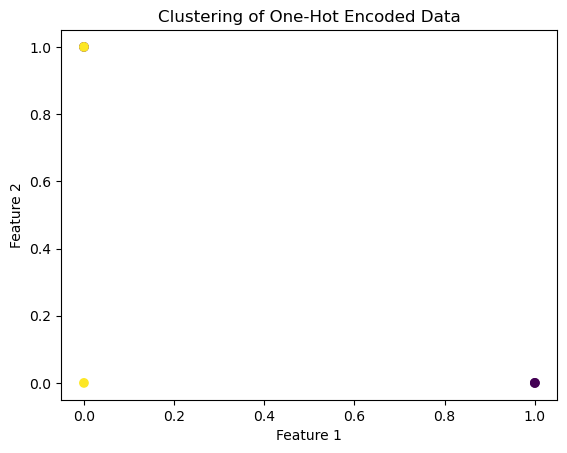

In [41]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Create a Spark session
spark = SparkSession.builder.appName("Clustering One Hot Encoded Data").getOrCreate()

# Example DataFrame with multiple categorical columns
data = [
    ("red", "small"),
    ("blue", "large"),
    ("green", "medium"),
    ("blue", "small"),
    ("red", "medium"),
]
df = spark.createDataFrame(data, ["color", "size"])

# Step 1: One-Hot Encoding
# List of categorical columns to encode
categorical_cols = ["color", "size"]
indexers = []
encoders = []

for col in categorical_cols:
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_index")
    encoder = OneHotEncoder(inputCols=[f"{col}_index"], outputCols=[f"{col}_ohe"])
    indexers.append(indexer)
    encoders.append(encoder)

# Create a Pipeline for One-Hot Encoding
pipeline = Pipeline(stages=indexers + encoders)
model = pipeline.fit(df)
df_encoded = model.transform(df)

# Step 2: Assemble One-Hot Encoded Vectors
# Collect all one-hot encoded columns
ohe_columns = [f"{col}_ohe" for col in categorical_cols]

# Use VectorAssembler to combine them into a single feature vector
assembler = VectorAssembler(inputCols=ohe_columns, outputCol="features")
df_features = assembler.transform(df_encoded)
df_features.show()

# Step 3: KMeans Clustering
kmeans = KMeans(k=2, seed=1)  # Set k (number of clusters)
model_kmeans = kmeans.fit(df_features)

# Step 4: Make predictions and evaluate
predictions = model_kmeans.transform(df_features)

# Show the results
print("DataFrame with Clustering Results:")
predictions.select("color", "size", "features", "prediction").show()

# Optional: To visualize the clusters using matplotlib
# Note: This is only for illustration. You would need to convert to a pandas DataFrame for visualization.
# Here we extract the data for visualization.
clustered_data = predictions.select("features", "prediction").toPandas()

# Convert SparseVector to dense for easier plotting
clustered_data['features'] = clustered_data['features'].apply(lambda x: x.toArray())

# Split features into separate columns for plotting
features_array = np.vstack(clustered_data['features'].values)
plt.scatter(features_array[:, 0], features_array[:, 1], c=clustered_data['prediction'], cmap='viridis')
plt.title('Clustering of One-Hot Encoded Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [27]:
df_features.show()

+-----+------+-----------+----------+-------------+-------------+-----------------+
|color|  size|color_index|size_index|    color_ohe|     size_ohe|         features|
+-----+------+-----------+----------+-------------+-------------+-----------------+
|  red| small|        1.0|       1.0|(2,[1],[1.0])|(2,[1],[1.0])|[0.0,1.0,0.0,1.0]|
| blue| large|        0.0|       2.0|(2,[0],[1.0])|    (2,[],[])|    (4,[0],[1.0])|
|green|medium|        2.0|       0.0|    (2,[],[])|(2,[0],[1.0])|    (4,[2],[1.0])|
| blue| small|        0.0|       1.0|(2,[0],[1.0])|(2,[1],[1.0])|[1.0,0.0,0.0,1.0]|
|  red|medium|        1.0|       0.0|(2,[1],[1.0])|(2,[0],[1.0])|[0.0,1.0,1.0,0.0]|
+-----+------+-----------+----------+-------------+-------------+-----------------+



In [ ]:
cats = df.select("Category").distinct().collect()
cats_list = [row['Category'] for row in cats]
print(cats_list)

In [37]:
crime_cat = df.groupBy("Category").count().toPandas()
crime_cat = crime_cat.sort_values(by="count")

In [ ]:

# Plot the pie chart
plt.figure(figsize=(6,6))
plt.pie(crime_cat['count'], labels=crime_cat['Category'], autopct='%1.1f%%', startangle=90)
plt.title('Crime Category Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
for cat in cats_list:
    crime_df = df.filter(F.col("Category") == cat)
    df_pd = crime_df.select("LAT", "LON").toPandas()
    coords = df_pd.values
    db = DBSCAN(eps=0.1, min_samples=1000).fit(coords)
    labels = db.labels_

    df_pd["Cluster"] = labels
    hotspots = df_pd[df_pd["Cluster"] !=1]
    heatmap_data = list(zip(hotspots['LAT'], hotspots['LON']))

    # Create a folium map centered at an average location
    m =  folium.Map(location=[hotspots['LAT'].mean(), hotspots['LON'].mean()], zoom_start=12)

    # Add the heatmap layer
    HeatMap(heatmap_data, radius=15, blur=10).add_to(m)
    filename = f"heatmaps/crime_hotspots_{cat}.html"
    # Show the map (or save to file)
    m.save(filename)

# K-Modes.Kprototypes

In [ ]:
from kmodes.kprototypes import KPrototypes

# Example mixed data
data = np.array([
    [34, 'Red'],
    [25, 'Blue'],
    [29, 'Green'],
    [42, 'Red'],
    [41, 'Green']
])

# Fit the K-Prototypes model
kproto = KPrototypes(n_clusters=2, init='Cao', verbose=2)
clusters = kproto.fit_predict(data, categorical=[1])

print(clusters)